__собираем статистики по объявлениям о продаже земли__

_Evgeny S. Borisov <parser@mechanoid.su>_

In [1]:
!date

Чт 13 июн 2024 12:40:24 MSK


# загружаем данные

In [2]:
import pandas as pd
import geopandas as gpd

pd.set_option('display.max_colwidth', None)
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
df = pd.read_pickle('data/2024/df_land.pkl')
df['dt'] = df['ts'].dt.date
display( len(df) )
cols = ['title','address','latitude','longitude','priceM','dt']
display( df.sample(3)[cols] )

14209

title  \
8807  участок 10 сот. (снт, днп)   
9619      участок 4,4 сот. (ижс)   
8087       участок 12 сот. (ижс)   

                                                                          address  \
8807  бахчисарай,садоводческое товарищество собственников недвижимости надежда,50   
9619                                севастополь,садоводческое товарищество карань   
8087                                      бахчисарай,с.новоульяновка,горная ул.,1   

       latitude  longitude  priceM          dt  
8807  57.246091  37.768912    0.80  2024-06-13  
9619  44.506023  33.549093    2.50  2024-06-13  
8087  44.606568  33.866594    0.85  2024-06-10

---

In [4]:
df_ = pd.read_pickle('data/2023/data_land.pkl').rename(columns={'adr':'address'})
df_['dt'] = df_['ts'].dt.date
display( len(df_) )
display( df_.sample(3)[cols] )

18854

title                                     address  \
4566   Участок 14,5 сот. (ИЖС)  Севастополь,с. Широкое, Приозёрная ул., 50   
14567     Участок 4 сот. (ИЖС)         Севастополь,Балаклава, Склонная ул.   
7995      Участок 4 сот. (ИЖС)                        Севастополь, Фиолент   

        latitude  longitude  priceM          dt  
4566   44.480908  33.759272    3.75  2022-09-16  
14567  44.519656  33.586212    2.50  2022-11-15  
7995   44.544613  33.455732    1.70  2022-09-26

In [5]:
df_ = (
        df_
        .dropna(subset=['dt','url'])
        .drop_duplicates(['dt','url'])
        .drop(columns=['adr_orig','obj_name','avito_page'])
    )
display( len(df_) )
cols = ['title','address','latitude','longitude','priceM','dt','url']
display( df_.sample(3)[cols] )

18727

title                                      address  \
18743  Участок 6,7 сот. (ИЖС)       Севастополь,Балаклава, Арктическая ул.   
5946    Участок 11 сот. (ИЖС)                      Севастополь,с. Тенистое   
14024    Участок 5 сот. (ИЖС)  Севастополь,СТ Дачник, 1-я Воронцовская ул.   

        latitude  longitude  priceM          dt                          url  
18743  44.507662  33.604133    4.90  2024-06-05  https://avito.ru/3611058628  
5946   44.742718  33.669513    1.10  2022-09-19  https://avito.ru/2420366883  
14024  44.582157  33.568982    5.20  2022-11-07  https://avito.ru/2391224207

In [6]:
# df_['dt'].drop_duplicates()

In [7]:
# history_date = df_['dt'].max()
history_date = pd.to_datetime('2023-01-10').date()
display(history_date)

datetime.date(2023, 1, 10)

In [8]:
df = pd.concat([df,df_]).reset_index(drop=True)
display( len(df) )
del df_

32936

In [9]:
import numpy as np
df['log_priceM'] = df['priceM'].apply(lambda x: np.log(x+1.))

---

In [10]:
# df['dt'].drop_duplicates().sort_values()

In [11]:
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-04').date() ]
# display( len(df) )
# df = df[ df['dt']!=pd.to_datetime('2024-06-05').date() ]
# display( len(df) )
# df = df.reset_index(drop=True)

In [12]:
df['month'] = df['ts'].dt.to_period('M')

---

In [13]:
df['latitude'] = pd.to_numeric( df['latitude'], errors='coerce' )
df['longitude'] = pd.to_numeric( df['longitude'], errors='coerce' )

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32936 entries, 0 to 32935
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   url                 32936 non-null  object        
 1   place               32936 non-null  object        
 2   title               32936 non-null  object        
 3   subtitle            5105 non-null   object        
 4   price               32936 non-null  int64         
 5   address             32936 non-null  object        
 6   description         32936 non-null  object        
 7   ts                  32936 non-null  datetime64[ns]
 8   area                32936 non-null  float64       
 9   is_IJS              32936 non-null  bool          
 10  priceM              32936 non-null  float64       
 11  priceMU             32936 non-null  float64       
 12  area_size_category  32882 non-null  category      
 13  address_orig        14209 non-null  object    

In [15]:
df.loc[ df['address']=='квартал Старый Город', ['latitude','longitude']] = None
df.loc[ df['url']=='https://avito.ru/2322251740', ['latitude','longitude']] = None

df.loc[ df['address']=='Севастополь,Чёрное море', ['latitude','longitude'] ] = None
df.loc[ df['address'].str.lower().str.match('чёрное море'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match('анталья'), ['latitude','longitude'] ] = None 


df.loc[ df['address'].str.lower().str.match(r'бахчисарай.*надежда.*'), ['latitude','longitude'] ] = None 
df.loc[ df['address'].str.lower().str.match(r'бахчисарай.*с.дачное.*'), ['latitude','longitude'] ] = None 

df.loc[ df['longitude']<30., ['latitude','longitude'] ] = None 

In [ ]:
df.loc[ df['address'].str.lower().str.match(r'.*мысовское.*'), 'place' ] = 'kerch'


In [16]:
display( len(df) )
df = df.dropna(subset=['latitude','longitude'])
display( len(df) )

32936

32909

In [17]:
# print(len(df))
# # выкидываем "ущербные" варианты 
# df = df.query('is_IJS')
# print(len(df))

In [18]:
gdf = gpd.GeoDataFrame( df, geometry = gpd.points_from_xy( df['longitude'], df['latitude']), crs='epsg:4326', )
# [['title','address','latitude','longitude','priceM']] 
display( gdf.sample(3)[cols])

title  \
18154          Участок 6 сот. (ИЖС)   
4212   участок, 4 сот., садоводство   
8234     участок 85 сот. (снт, днп)   

                                               address  latitude  longitude  \
18154  Севастополь,садовое товарищество Строитель, 332     44.57      33.50   
4212     севастополь,р-н гагаринский,снт рябинушка тсн     44.57      33.46   
8234              бахчисарай,пгт.куйбышево,ул.ленина,1     44.63      33.86   

       priceM          dt                                                  url  
18154    3.15  2022-09-15                          https://avito.ru/2277016568  
4212     1.85  2024-06-10  https://sevastopol.cian.ru/sale/suburban/301543376/  
8234     7.00  2024-06-10                      https://www.avito.ru/3741825689

In [19]:
gdf = gdf.query('place in ("bahchisaray","sudak","sevastopol")')

---

In [20]:
dt_max = df['dt'].max()
dt_min = df['dt'].min()
display( dt_min,history_date,dt_max )

datetime.date(2022, 9, 8)

datetime.date(2023, 1, 10)

datetime.date(2024, 6, 13)

In [21]:
# gdf_history = gdf.query(f'dt <= @history_date')
# gdf = gdf.query(f'dt > @history_date')

In [22]:
# display( len(gdf_history) )
display( len(gdf) )

32908

In [23]:
# cols = ['title','address','latitude','longitude','priceM','dt','place','url']
# gdf[ (gdf['place']=='sevastopol') & (gdf['address'].str.match(r'.*Судак.*')) ][cols]

In [24]:
# gdf['place'].unique()

# общая статистика

In [25]:
gdf[['title','address','priceM','geometry']].sample(512).explore()

In [26]:
gdf.query('place=="sevastopol"')[['title','address','priceM','geometry']].sample(512).explore()

In [27]:
( 
    gdf.query('place=="sudak"')
    [['title','address','priceM','area_size_category','geometry']]
    #.explore('area_size_category', legend=True) 
    .explore()    
)

In [28]:
# gdf[
#     gdf['address'].str.match(r'бахчисарай.*с.дачное.*')
# ][['title','address','priceM','area_size_category','geometry']]

In [29]:
(
    gdf.query('place=="bahchisaray"')
    [['title','address','priceM','area_size_category','geometry']]
    #.sample(100)
    .explore() #'area_size_category', legend=True) 
)

In [30]:
# cols = ['title','adr','priceM','house_size_category','place','url','geometry']

In [31]:
percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = gdf.groupby(['place','area_size_category','month'],observed=True)['priceM'].describe(percentiles=percentiles)
display( stat )

count  mean   std  min   1%   5%  \
place       area_size_category month                                        
bahchisaray <1                 2024-06    8.00  0.90  0.11 0.80 0.80 0.80   
            1-2                2024-06   20.00  2.60  2.33 0.50 0.50 0.50   
            2-4                2024-06   22.00  3.21  1.26 1.80 1.80 1.80   
            4-8                2024-06  489.00  2.00  1.26 0.15 0.30 0.40   
            8-20               2024-06  600.00  2.22  2.31 0.23 0.30 0.45   
            20+                2024-06 1395.00  5.42 10.40 0.00 0.00 0.35   
sevastopol  <1                 2022-09   31.00  4.32  6.41 0.30 0.30 0.30   
                               2022-10    8.00  2.44  5.09 0.30 0.30 0.30   
                               2022-11   23.00  3.89  6.02 0.30 0.30 0.30   
                               2023-01    2.00  0.35  0.07 0.30 0.30 0.30   
                               2024-06  161.00  2.96  1.09 0.80 0.80 0.80   
            1-2                2022-09   37.00  1.39  0.49 0.65 0.65 0.65   
                               2022-10   14.00  1.76  1.16 0.65 0.65 0.65   
                               2022-11   22.00  1.89  1.16 0.65 0.65 0.65   
                               2023-01    6.00  2.94  3.51 0.65 0.68 0.79   
                               2024-06  204.00  3.98  3.20 0.55 0.55 1.00   
            2-4                2022-09 1204.00  3.51  2.25 0.00 0.68 1.35   
                               2022-10  304.00  3.36  1.89 0.00 0.61 1.40   
                               2022-11  729.00  2.96  1.57 0.00 0.69 1.25   
                               2023-01  112.00  3.01  1.64 0.68 0.77 1.30   
                               2024-06 2371.00  3.33  2.04 0.65 1.30 1.70   
            4-8                2022-09 4428.00  4.38  3.88 0.00 0.82 1.49   
                               2022-10 1119.00  4.26  3.55 0.00 0.93 1.45   
                               2022-11 2622.00  4.11  3.88 0.00 0.95 1.45   
                               2023-01  416.00  4.05  3.91 0.00 0.90 1.40   
                               2024-06 5190.00  4.17  3.48 0.35 0.88 1.40   
            8-20               2022-09 2790.00  6.29  6.35 0.00 0.80 1.60   
                               2022-10  701.00  6.03  6.06 0.00 1.00 1.50   
                               2022-11 1579.00  5.80  5.24 0.00 0.98 1.45   
                               2023-01  267.00  5.92  5.26 0.00 0.77 1.26   
                               2024-06 2976.00  5.86  8.16 0.00 0.90 1.50   
            20+                2022-09  308.00 31.56 31.68 0.00 0.80 2.10   
                               2022-10   62.00 25.69 24.79 0.00 0.00 0.84   
                               2022-11  177.00 30.13 27.39 1.00 1.50 1.55   
                               2023-01   23.00 41.50 48.51 1.55 1.87 3.15   
                               2024-06 1073.00 12.08 24.88 0.00 0.50 1.37   
sudak       <1                 2024-06   35.00  1.30  1.15 0.50 0.50 0.50   
            1-2                2024-06   19.00  4.25  1.75 2.00 2.00 2.00   
            2-4                2024-06   66.00  5.46  4.54 0.94 1.37 1.60   
            4-8                2024-06  840.00  3.48  3.18 0.00 0.60 1.09   
            8-20               2024-06  279.00  5.99  6.08 0.88 0.88 1.10   
            20+                2024-06  122.00 10.60  8.15 0.80 0.80 1.50   

                                        10%   25%   50%   75%   90%    95%  \
place       area_size_category month                                         
bahchisaray <1                 2024-06 0.80  0.80  0.90  1.00  1.00   1.00   
            1-2                2024-06 0.50  1.50  2.00  2.00  7.00   7.00   
            2-4                2024-06 1.80  2.50  2.80  3.68  5.59   5.80   
            4-8                2024-06 0.50  1.00  1.90  2.50  3.80   4.70   
            8-20               2024-06 0.60  0.90  1.60  2.70  3.53   6.00   
            20+                2024-06 0.60  1.00  2.15  4.85 12.50  23.60   
sevastopol  <1              

In [32]:
import matplotlib.pyplot as plt

cols = ['1%','10%','25%','50%']
#sizes = stat.reset_index()['area_size_category'].unique()
sizes = [ '2-4', '4-8', '8-20']
display( sizes )

['2-4', '4-8', '8-20']

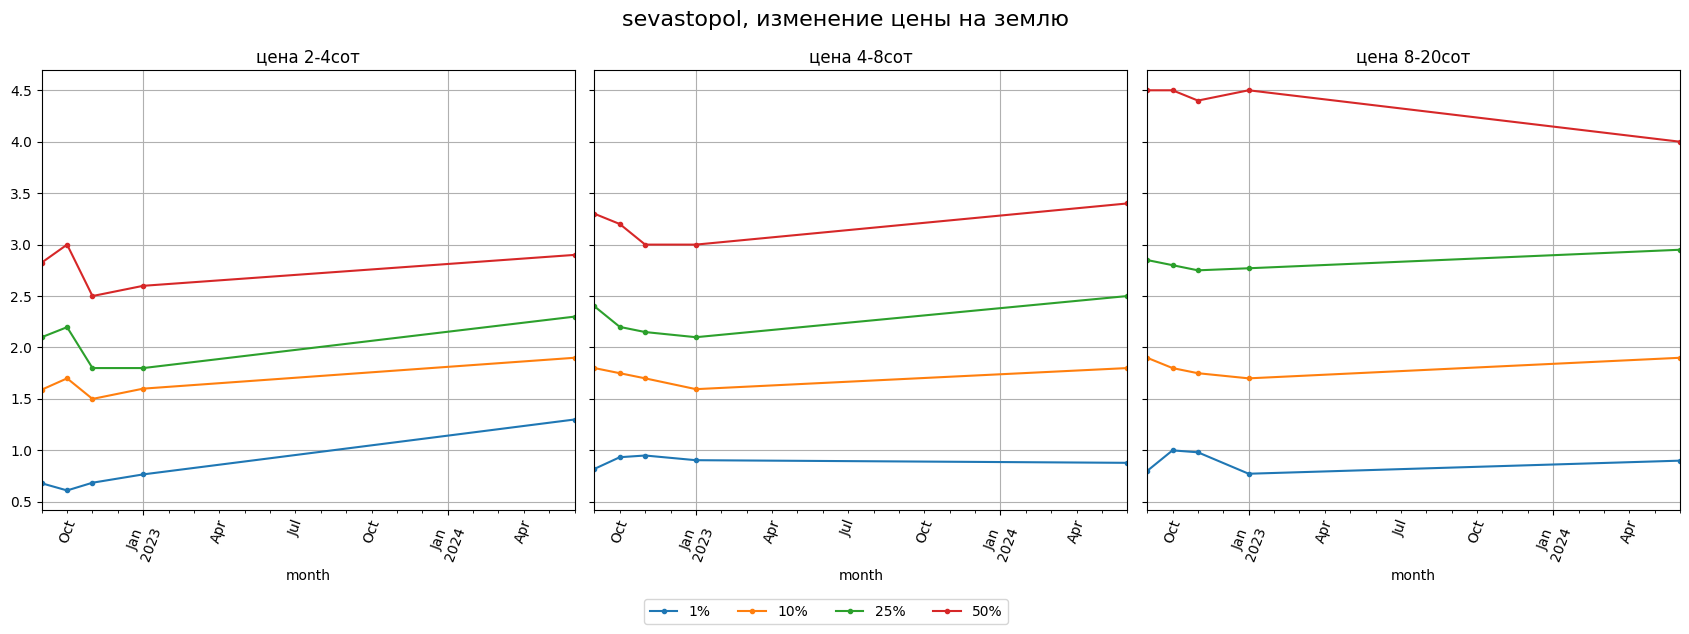

In [33]:
place = 'sevastopol'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/panda

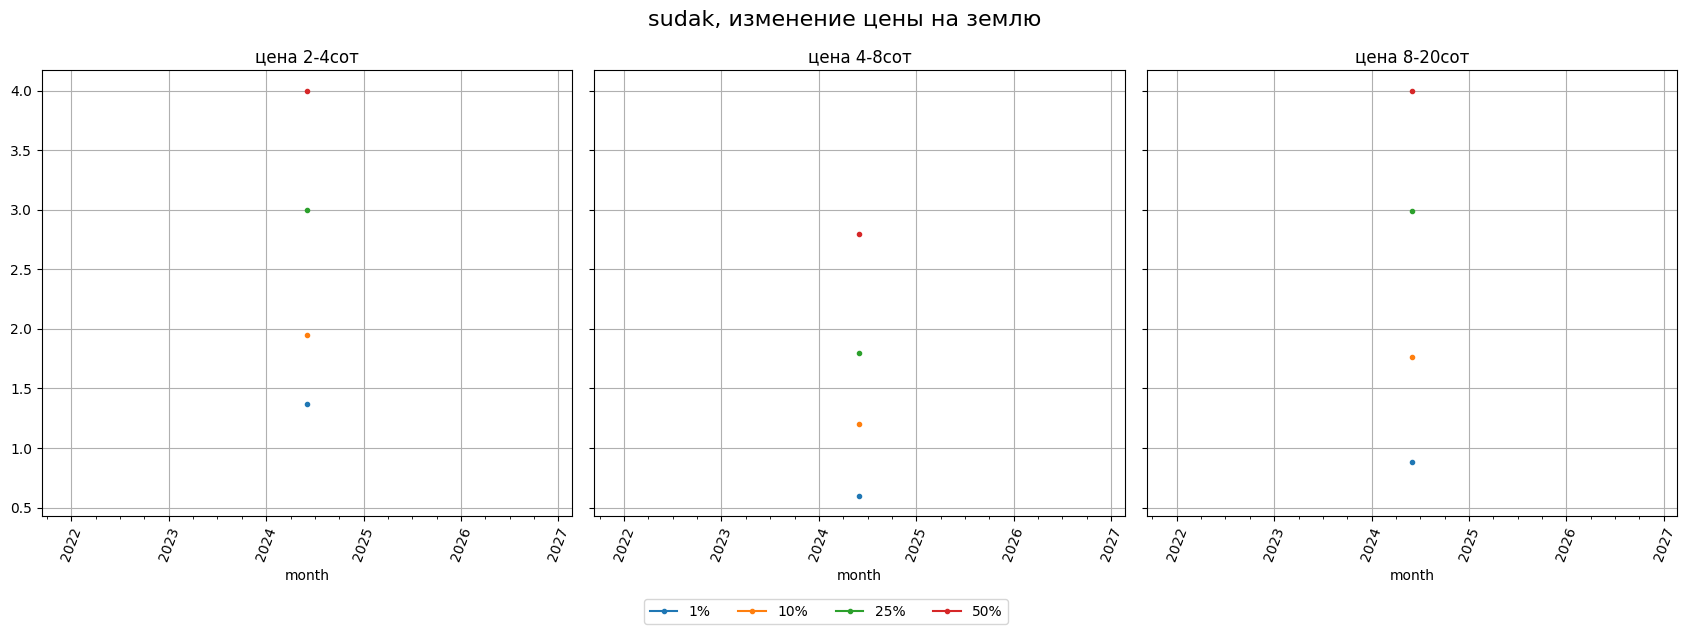

In [34]:
place = 'sudak'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/pandas/plotting/_matplotlib/core.py:1561: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set_xlim(left, right)
/opt/venv/avito_cp312/lib/python3.12/site-packages/panda

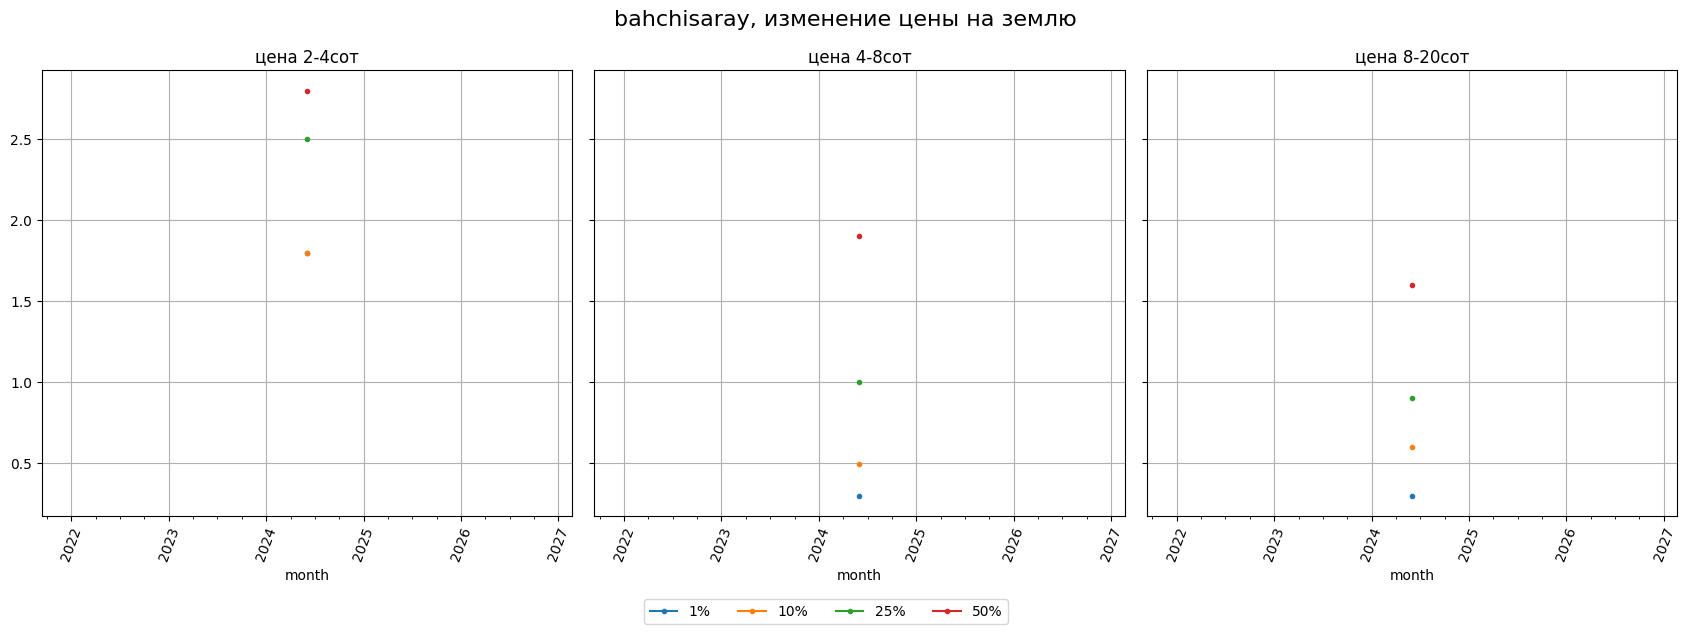

In [35]:
place = 'bahchisaray'

fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(place,s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'{place}, изменение цены на землю', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()

# актуальная цена

In [36]:
display(len(gdf))
gdf_last = gdf[ gdf['dt'] == gdf['dt'].max() ]
display(len(gdf_last))

32908

2826

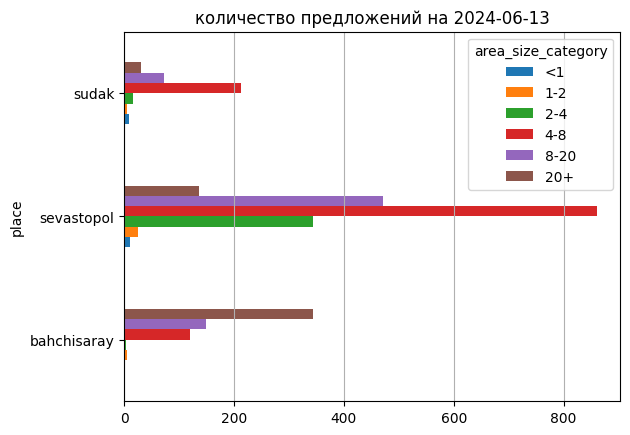

In [37]:
(
gdf_last
.groupby(['area_size_category','place'],observed=False)['url'].count().reset_index()
.pivot(index='place', columns='area_size_category', values='url')
.plot.barh(title='количество предложений на '+ str( gdf['dt'].max() ))
.grid(axis='x')    
)

In [38]:
(
    gdf_last
    .groupby(['place','area_size_category'],observed=False)
    ['priceM'].describe(percentiles=percentiles)
)

count  mean   std  min   1%   5%  10%  25%  \
place       area_size_category                                               
bahchisaray <1                   2.00  0.90  0.14 0.80 0.80 0.81 0.82 0.85   
            1-2                  5.00  2.60  2.53 0.50 0.54 0.70 0.90 1.50   
            2-4                  4.00  3.50  1.70 1.80 1.83 1.95 2.10 2.55   
            4-8                120.00  2.00  1.28 0.15 0.30 0.40 0.50 1.09   
            8-20               149.00  2.24  2.40 0.23 0.32 0.47 0.60 0.90   
            20+                344.00  5.41 10.45 0.00 0.00 0.36 0.60 1.00   
sevastopol  <1                  10.00  3.22  1.37 0.80 0.86 1.11 1.43 2.38   
            1-2                 25.00  5.13  4.34 1.00 1.00 1.10 1.66 2.30   
            2-4                344.00  3.50  2.37 0.65 1.40 1.72 1.90 2.30   
            4-8                860.00  4.37  3.70 0.35 0.83 1.50 1.95 2.60   
            8-20               471.00  6.48  8.60 0.60 1.09 1.50 2.10 3.20   
            20+                136.00 13.63 22.93 0.00 0.14 1.10 2.05 3.24   
sudak       <1                   8.00  1.24  1.03 0.50 0.50 0.52 0.54 0.62   
            1-2                  5.00  4.40  1.90 2.00 2.04 2.20 2.40 3.00   
            2-4                 17.00  5.73  4.64 1.60 1.66 1.88 2.34 3.00   
            4-8                212.00  3.42  3.01 0.50 0.80 1.10 1.21 1.80   
            8-20                72.00  6.40  7.07 0.88 0.97 1.16 1.80 3.00   
            20+                 31.00 10.60  8.15 0.80 1.01 2.10 2.85 4.95   

                                50%   75%   90%   95%    max  
place       area_size_category                                
bahchisaray <1                 0.90  0.95  0.98  0.99   1.00  
            1-2                2.00  2.00  5.00  6.00   7.00  
            2-4                3.20  4.15  5.14  5.47   5.80  
            4-8                1.90  2.50  3.71  4.71   6.90  
            8-20               1.60  2.70  3.59  5.60  16.20  
            20+                2.10  4.96 12.00 20.00 100.00  
sevastopol  <1                 3.55  3.98  4.90  4.90   4.90  
            1-2                4.20  5.90 11.10 14.46  18.50  
            2-4                2.90  3.82  5.77  7.77  22.40  
            4-8                3.50  5.00  7.50  9.50  70.00  
            8-20               4.80  7.00 10.90 15.00 120.00  
            20+                5.00 13.62 31.00 70.00 157.50  
sudak       <1                 0.80  1.50  2.13  2.86   3.60  
            1-2                4.80  5.50  6.22  6.46   6.70  
            2-4                4.50  6.10 11.00 14.00  20.00  
            4-8                2.80  3.82  5.90  8.00  30.00  
            8-20               4.25  7.24 11.50 19.45  50.30  
            20+                7.50 15.40 22.00 28.50  30.00

In [39]:
# gdf_last['area_size_category'].unique()

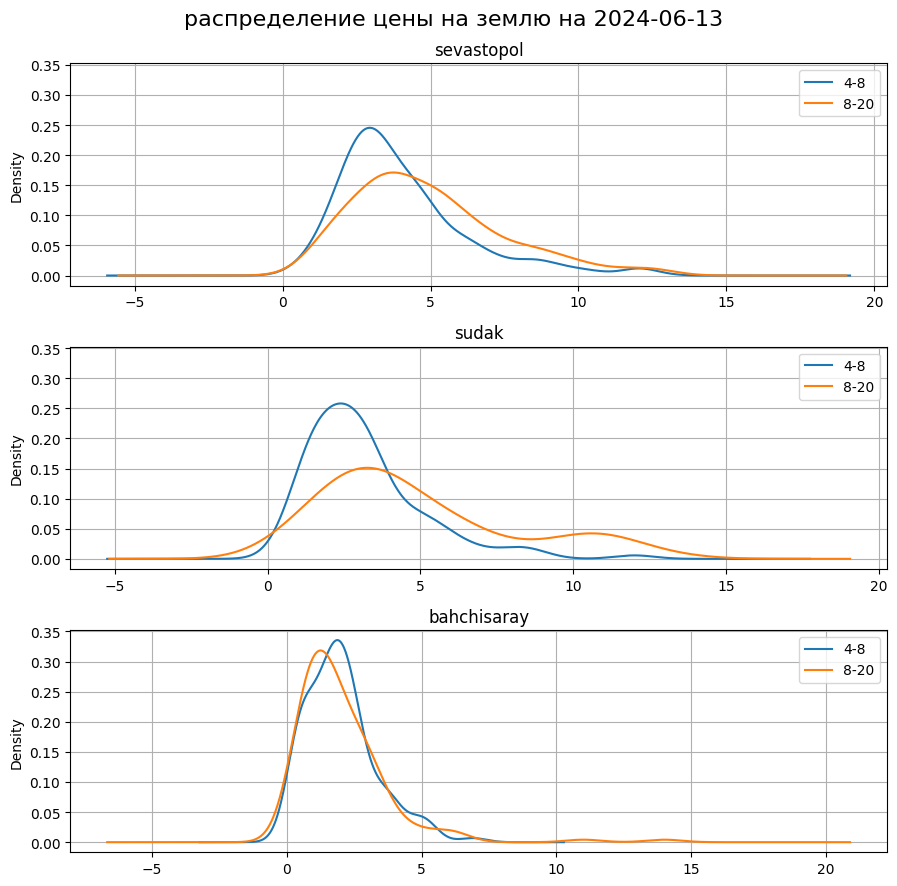

In [40]:
q_95 = gdf_last.groupby(['place'])['priceM'].quantile(.95)

places = ['sevastopol','sudak','bahchisaray']
# category = ['4-8', '8-20', '20+', '2-4', '1-2', NaN, '<1']
category = ['4-8', '8-20']

fig, ax = plt.subplots(len(places),1,figsize=(9,9), sharey=True )
for i,p in enumerate(places): 
    (
        gdf_last
        .query(f'(place=="{p}")&(priceM<{q_95[p]})&(area_size_category in {category})')
        .groupby(['area_size_category'],observed=True)
        ['priceM']
        .plot.kde(legend=True,ax=ax[i],title=f'{p}', grid=True)   
    )
fig.suptitle(f'распределение цены на землю на '+ str( gdf_last['dt'].max() ), fontsize=16)
fig.tight_layout()

# цены на карте

In [41]:
import h3
from shapely.geometry import Polygon
from shapely.geometry import MultiPoint

In [42]:
def cover_grid_hexagonal(gmtr,cell_size=6,crs='EPSG:4326'):
    polygonise = lambda hex_id: Polygon( h3.h3_to_geo_boundary( hex_id, geo_json=True)  )
    hexs = list(h3.polyfill( gmtr.__geo_interface__, cell_size, geo_json_conformant = True ))
    return gpd.GeoDataFrame({ 'hex_id': hexs,  'geometry': list(map(polygonise, hexs)), },crs=crs,)

In [43]:
# cols = ['title','address','latitude','longitude','priceM','dt','url']
# gdf_last.query('place=="sevastopol"')[cols]

In [44]:
# gdf_last[gdf_last['place']=='sevastopol'][cols]

## Севастополь

In [45]:
frame_sevastopol = gpd.GeoDataFrame([{ # все предложения
            'place':'sevastopol', 
            'geometry':MultiPoint( gdf_last.query('place=="sevastopol"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

frame_sevastopol.explore()

In [46]:
# gdf_last.query('place=="sevastopol"')[['priceM']].describe([.9,.95,.99]).T

In [47]:
grid = cover_grid_hexagonal( frame_sevastopol.geometry.values[0],cell_size=7 )
grid_values = ( 
    grid
    # .sjoin( gdf_last.query('(place=="sevastopol")&(priceM<10.0)'), how='inner',)
    .sjoin( gdf_last.query('place=="sevastopol"'), how='inner',)
    .groupby(['hex_id'])
    [['log_priceM','priceM']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceM','geometry','log_priceM',]]
    .explore(column='log_priceM',cmap='rainbow')
)

## Судак

In [48]:
frame_sudak = gpd.GeoDataFrame([{ # все предложения
            'place':'sudak', 
            'geometry':MultiPoint( gdf_last.query('place=="sudak"')['geometry'].tolist() ).convex_hull, 
        }],crs='EPSG:4326')

In [49]:
# gdf_last.query('place=="sudak"')[['priceM']].describe([.9,.95,.99]).T

In [50]:
grid = cover_grid_hexagonal( frame_sudak.geometry.values[0],cell_size=8 )
grid_values = ( 
    grid
    .sjoin( gdf_last.query('place=="sudak"'), how='inner',)
    .groupby(['hex_id'])
   [['log_priceM','priceM']]
    .median()
    .reset_index()
)

(
    grid
    .merge(grid_values,on='hex_id')
    [['priceM','geometry','log_priceM',]]
    .explore(column='log_priceM',cmap='rainbow')
)

# районы Севастополя

In [51]:
# загружаем области поиска
frames_path = 'data/frames/'
frames_index = pd.read_csv(f'{frames_path}/_index.tsv',sep='\t')

swap_coo = lambda coo : [ (c[1],c[0]) for c in coo ]
df2poly = lambda df : Polygon(swap_coo(df.values))

frames = gpd.GeoDataFrame([ 
        { 'area_name':nm, 'geometry': df2poly( pd.read_csv(f'{frames_path}/{f}',header=None) ) } 
        for nm,f in frames_index.values
    ],crs='epsg:4326',)

In [52]:
display(frames)

area_name  \
0     Севастополь, район Острякова   
1  Севастополь, парк 60-летия СССР   
2  Севастополь, Хрусталёва/Хрюкина   
3  Севастополь, Геловани/Коломийца   
4     Севастополь, Музыки/Бирюзова   
5   Севастополь, кр.горка (старый)   
6    Севастополь, кр.горка (новый)   
7      Севастополь, Малахов курган   
8       Севастополь, Благополучный   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        geometry  
0                                                                                                                                                                                                                                                                                                                                                                                                                                                                          POLYGON ((33.51618 44.58832, 33.52597 44.58817, 33.53399 44.57315, 33.54248 44.55177, 33.52583 44.55023, 33.51174 44.57861, 33.51253 44.58565, 33.51253 44.58565, 33.51618 44.58832))  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   POLYGON ((33.51805 44.58404, 33.51458 44.58408, 33.51263 44.58031, 33.51435 44.57460, 33.52004 44.57520, 33.51805 44.58404))  
2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52003 44.57511, 33.52527 44.56364, 33.52116 44.56136, 33.51942 44.56406, 33.51951 44.56384, 33.51874 44.56882, 33.51426 44.57444, 33.52003 44.57511))  
3                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             POLYGON ((33.52139 44.57296, 33.53034 44.57518, 33.53318 44.57413, 33.53369 44.57139, 33.53244 44.56878, 33.53123 44.56774, 33.52440 44.56640, 33.52139 44.57296))  
4                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [53]:
frames.explore('area_name', legend=True)

In [54]:
area_name=[
    #'Севастополь, парк 60-летия СССР',
    #'Севастополь, Хрусталёва/Хрюкина',
    #'Севастополь, район Острякова',
    #'Севастополь, Малахов курган',
    'Севастополь, кр.горка (старый)',
    'Севастополь, кр.горка (новый)',
    'Севастополь, Благополучный',
    ]

In [55]:
# выбираем область
frame_ = frames[frames['area_name'].isin(area_name)]

# фильтруем данные по области
gdf_last_local = gdf_last.sjoin( frame_, how='inner', predicate='within') 
gdf_last_local[['title','priceM','address','geometry']].explore( legend=False)

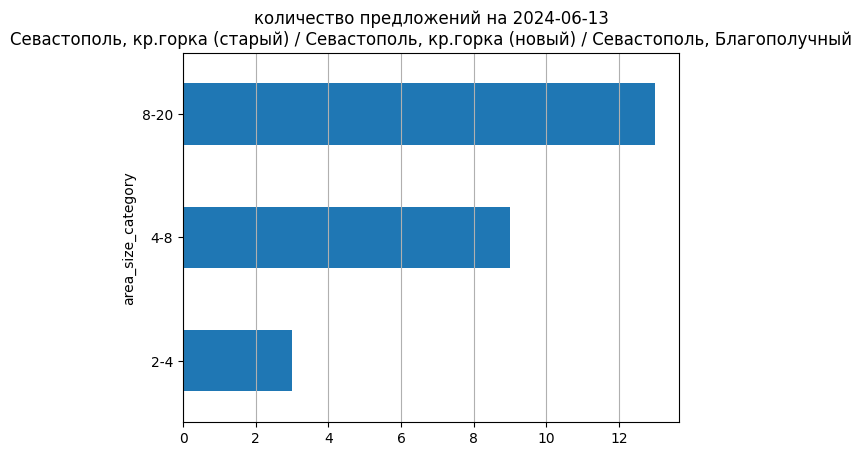

In [56]:
(
        gdf_last_local
        .groupby(['area_size_category'], observed=True)['url'].count()
        .plot.barh(title='количество предложений на '+ str( gdf['dt'].max()) + '\n' + ' / '.join(area_name) )
        .grid(axis='x')    
    )

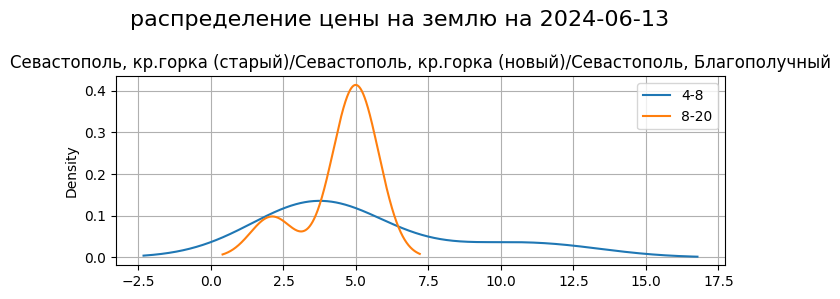

In [57]:
q_95 = gdf_last_local['priceM'].quantile(.95)

fig, ax = plt.subplots(figsize=(7,3) )
(
    gdf_last_local
    .query(f'(priceM<{q_95})&(area_size_category in {category})')
    .groupby(['area_size_category'],observed=True)
    ['priceM'].plot.kde(legend=True,ax=ax,title='/'.join(area_name), grid=True)   
)
fig.suptitle(f'распределение цены на землю на '+ str( gdf_last_local['dt'].max() ), fontsize=16)
fig.tight_layout()

----

In [58]:
# изменение цены по району
gdf_local = gdf.sjoin( frame_, how='inner', predicate='within') 

In [59]:
# percentiles=[.01,.05,.1,.25,.5,.75,.9,.95]
stat = gdf_local.groupby(['area_size_category','month'],observed=True)['priceM'].describe(percentiles=percentiles)
display( stat )

count  mean  std  min   1%   5%  10%  25%  50%  \
area_size_category month                                                     
<1                 2024-06   3.00  3.70 0.00 3.70 3.70 3.70 3.70 3.70 3.70   
2-4                2022-09  59.00  2.84 0.64 1.90 1.90 2.45 2.45 2.60 2.65   
                   2022-10  16.00  2.62 0.53 1.90 1.90 1.90 2.05 2.25 2.62   
                   2022-11  45.00  2.59 0.47 2.00 2.00 2.00 2.14 2.35 2.40   
                   2023-01   6.00  2.50 0.65 1.90 1.90 1.92 1.95 2.09 2.35   
                   2024-06  18.00  4.26 2.00 1.80 1.80 1.80 1.80 2.80 4.40   
4-8                2022-09 216.00  3.64 1.69 1.45 1.45 1.80 1.80 2.20 3.20   
                   2022-10  54.00  3.71 1.55 1.80 1.80 1.90 2.00 2.30 3.25   
                   2022-11 119.00  3.65 1.60 1.60 1.62 1.80 1.95 2.30 3.20   
                   2023-01  14.00  3.76 1.38 1.50 1.56 1.82 2.09 2.52 4.08   
                   2024-06  75.00  5.22 2.76 2.45 2.45 2.45 2.55 3.20 4.20   
8-20               2022-09 114.00  6.43 3.91 2.15 2.15 2.56 3.00 4.06 4.93   
                   2022-10  20.00  5.22 2.68 2.90 2.90 2.90 2.90 3.90 4.80   
                   2022-11  55.00  5.21 3.36 2.60 2.76 2.90 2.90 3.60 4.20   
                   2023-01   9.00  5.89 4.04 2.50 2.52 2.62 2.74 4.10 4.50   
                   2024-06  87.00  6.12 3.93 2.10 2.10 2.10 2.94 4.28 4.95   
20+                2024-06   3.00  4.50 0.00 4.50 4.50 4.50 4.50 4.50 4.50   

                            75%   90%   95%   max  
area_size_category month                           
<1                 2024-06 3.70  3.70  3.70  3.70  
2-4                2022-09 2.80  3.70  3.70  6.50  
                   2022-10 2.78  3.35  3.70  3.70  
                   2022-11 2.70  3.42  3.70  3.70  
                   2023-01 2.61  3.20  3.45  3.70  
                   2024-06 6.00  6.50  6.50  6.50  
4-8                2022-09 4.72  6.00  6.62  8.50  
                   2022-10 4.80  6.21  6.60  6.70  
                   2022-11 4.65  6.30  6.60  8.50  
                   2023-01 4.88  5.41  5.54  5.60  
                   2024-06 6.60  9.50 12.00 12.00  
8-20               2022-09 6.60 12.00 15.00 17.00  
                   2022-10 5.80  6.74  8.35 15.00  
                   2022-11 4.85  7.84 12.90 20.00  
                   2023-01 4.70 12.34 13.02 13.70  
                   2024-06 5.50 12.85 16.00 16.00  
20+                2024-06 4.50  4.50  4.50  4.50

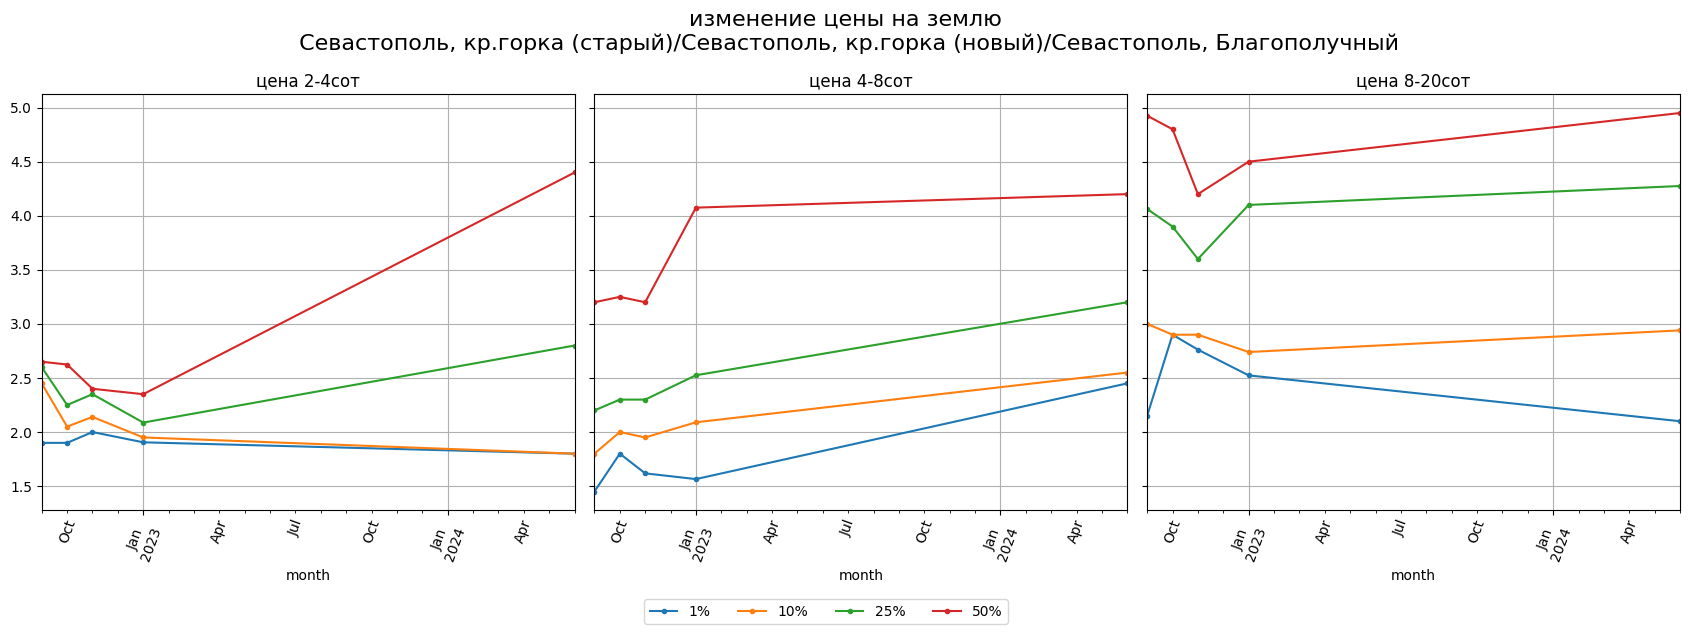

In [60]:
fig, ax = plt.subplots(1,len(sizes),figsize=(17,6), sharey=True )

for i,s in enumerate(sizes): 
    stat.loc[(s),cols].plot(title=f'цена {s}сот', grid=True,ax=ax[i],legend=False, rot=70, style='.-' )   

fig.suptitle(f'изменение цены на землю\n {'/'.join(area_name)}', fontsize=16)
fig.legend( labels=cols,frameon=True, ncol=len(cols), bbox_to_anchor=(0.6, 0.01))    
fig.tight_layout()